https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

from custom_functions import *
from datetime import time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 100

In [2]:
path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
df = pd.read_csv(path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47213 entries, 0 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47213 non-null  object
 1   Subject ID                47213 non-null  object
 2   GO / SC Num               47213 non-null  object
 3   Terry Stop ID             47213 non-null  object
 4   Stop Resolution           47213 non-null  object
 5   Weapon Type               47213 non-null  object
 6   Officer ID                47213 non-null  object
 7   Officer YOB               47213 non-null  object
 8   Officer Gender            47213 non-null  object
 9   Officer Race              47213 non-null  object
 10  Subject Perceived Race    47213 non-null  object
 11  Subject Perceived Gender  47213 non-null  object
 12  Reported Date             47213 non-null  object
 13  Reported Time             47213 non-null  object
 14  Initial Call Type     

In [4]:
df['Subject Perceived Race'].value_counts(normalize=True)

White                                        0.488255
Black or African American                    0.297503
Unknown                                      0.055620
-                                            0.040095
Hispanic                                     0.035668
Asian                                        0.032533
American Indian or Alaska Native             0.028784
Multi-Racial                                 0.017135
Other                                        0.003219
Native Hawaiian or Other Pacific Islander    0.001186
Name: Subject Perceived Race, dtype: float64

In [5]:
df.loc[df['Subject Perceived Race'] == 'White', 'Arrest Flag'].value_counts(normalize=True)

N    0.927295
Y    0.072705
Name: Arrest Flag, dtype: float64

In [6]:
df.loc[df['Subject Perceived Race'] == 'Black', 'Arrest Flag'].value_counts(normalize=True)

Series([], Name: Arrest Flag, dtype: float64)

In [7]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------

# Subject Age Group
df['Subject Age Group'].replace('-', np.nan, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', np.nan, inplace=True)

# Weapon Type
df['Weapon Type'].replace('-', 'None', inplace=True)
df['Weapon Type'].replace('Firearm Other', 'Firearm', inplace=True)
df['Weapon Type'].replace('Other Firearm', 'Firearm', inplace=True)
df['Weapon Type'].replace('Firearm (unk type)', 'Firearm', inplace=True)
df['Weapon Type'].replace('None/Not Applicable', 'None', inplace=True)
df['Weapon Type'].replace('Brass Knuckles', 'Club, Blackjack, Brass Knuckles', inplace=True)
df['Weapon Type'].replace('Blackjack', 'Club, Blackjack, Brass Knuckles', inplace=True)
df['Weapon Type'].replace('Club', 'Club, Blackjack, Brass Knuckles', inplace=True)
df['Weapon Type'].replace('Shotgun', 'Rifle', inplace=True)

# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')

# Officer Race
df['Officer Race'].replace('Unknown', np.nan, inplace=True)
df['Officer Race'].replace('Not Specified', np.nan, inplace=True)

# Subject Perceived Race
df['Subject Perceived Race'].replace('-', np.nan, inplace=True)
df['Subject Perceived Race'].replace('Other', np.nan, inplace=True)
df['Subject Perceived Race'].replace('Unknown', np.nan, inplace=True)


# Subject Perceived Gender
df['Subject Perceived Gender'].replace('Unable to Determine', np.nan, inplace=True)
df['Subject Perceived Gender'].replace('-', np.nan, inplace=True)
df['Subject Perceived Gender'].replace('Unknown', np.nan, inplace=True)
df['Subject Perceived Gender'].replace('Male', 'M', inplace=True)
df['Subject Perceived Gender'].replace('Female', 'F', inplace=True)
# Regarding below line: only 4 individuals remained in the non-binary category after dropping rows with na's in relevant fields
# I'm reluctant to remove this category given the potential to investigate one tiny aspect of the societal bias against 
# non-binary folks. However, with a sample size of 4, it is not statistically significant enough to provide meaningful results
df['Subject Perceived Gender'].replace('Gender Diverse (gender non-conforming and/or transgender)', np.nan, inplace=True)


# Reported Date
df['Reported Date'] = df['Reported Date'].astype('datetime64')

# Exclude for now simply because datetime.time shows up as 'object' type during ohe, which caused problems downstream
#if 'datetime.time' not in str(type(df['Reported Time'][0])): # Use if statement to avoid error when re-running
#    df['Reported Time'] = [time.fromisoformat(t) for t in df['Reported Time']]

# Reported Time
df['Reported Hour'] = [int(x[:2]) for x in df['Reported Time']]
    
# Call Type
df['Call Type'].replace('TEXT MESSAGE', '-', inplace=True)
df['Call Type'].replace('SCHEDULED EVENT (RECURRING)', '-', inplace=True)
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)

# Precinct
df['Precinct'].replace('-', 'Unknown', inplace=True)
df['Precinct'].replace('FK ERROR', 'Unknown', inplace=True)
#df['Precinct'].replace('OOJ', 'Unknown', inplace=True)
df['Precinct'].replace('SouthWest', 'Southwest', inplace=True)

# Sector
df['Sector'].replace('99', '-', inplace=True)

# Beat
df['Beat'].replace('S', '-', inplace=True)
df['Beat'].replace('99', '-', inplace=True)


# Categorize "Call Types". Variable used to create dictionary in CSV
call_types = pd.concat([df['Call Type'], df['Initial Call Type'], df['Final Call Type']]).value_counts().keys().values
path = os.path.join('..', 'data', 'categorize call types.csv')
call_type_dictionary = pd.read_csv(path)
call_type_dictionary = dict(zip(call_type_dictionary.iloc[:, 0], call_type_dictionary.iloc[:, 1]))


    
#--- INCOMPLETE!
df['Initial Call Type'] = df['Initial Call Type'].map(call_type_dictionary)
df['Final Call Type'] = df['Final Call Type'].map(call_type_dictionary)
df['Call Type'] = df['Call Type'].map(call_type_dictionary)


In [8]:
# Engineer new features

# Calculate Officer Age
if 'Officer YOB' in df.columns:
    df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']
    df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
    df.drop('Officer YOB', axis=1, inplace=True)

    
# Determine whether or not weapon was involved
#has_weapon = lambda x: 'No' if x == 'None' else 'Yes'
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')


# Calculate the number of stops per subject
if 'Subject ID' in df.columns:
    offense_ct_dict = dict(df['Subject ID'].value_counts())
    df['Offense Count'] = df['Subject ID'].map(offense_ct_dict)
    # Identify whether a subject has been involved in multiple stops
    df['Repeat Offender (Y/N)'] = (df['Offense Count'] > 1).astype('int')
    # Drop "Offense Count" for now given the number of missing values
    if 'Offense Count' in df:
        df.drop('Offense Count', axis=1, inplace=True)
    df.drop('Subject ID', axis=1, inplace=True)




# Identify whether race of officer is same as race of subject
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race']).astype('int')

# Identify whether gender of officer is same as gender of subject
df['Same Gender (Y/N)'] = (df['Officer Gender'] == df['Subject Perceived Gender']).astype('int')

In [9]:
# Rename columns and drop 'na' rows
if 'Arrest Flag' in df.columns:
    df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
    df.drop('Arrest Flag', axis=1, inplace=True)
    
if 'Frisk Flag' in df.columns:
    df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
    df.drop('Frisk Flag', axis=1, inplace=True)

# Remove missing values and reset index
#df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.dropna(inplace=True)
df['Officer Age'] = df['Officer Age'].astype('int')

# Graphical EDA

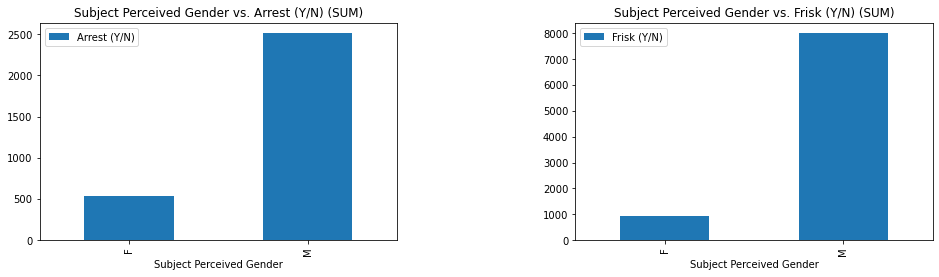

  Subject Perceived Gender  Arrest (Y/N)  Frisk (Y/N)
1                        M          2515         8007
0                        F           531          927
--------------------------------------------------------------------




In [20]:
# BAR GRAPHS FOR ***AVERAGE OR SUM*** OF METRICS

df_graphical = pd.concat([df, pd.get_dummies(df['Stop Resolution'], prefix='Resolution')], axis=1)

# Average metrics by age group
x_axis = 'Subject Age Group'
y_axis = ['Arrest (Y/N)', 'Frisk (Y/N)']#, 'Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
#bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=False)

# Average metrics by subject race
x_axis = 'Subject Perceived Race'
#y_axis = ['Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
#bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# Gender metrics
x_axis = 'Subject Perceived Gender'
y_axis = ['Arrest (Y/N)', 'Frisk (Y/N)']
bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# Officer race
x_axis = 'Officer Race'
#bar_plot(df_graphical, x_axis, y_axis, 'mean',verbose=True)

# Officer gender
x_axis = 'Officer Gender'
#bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer gender
x_axis = 'Officer Age'
#bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

In [13]:


































stop

NameError: name 'stop' is not defined

In [ ]:
# Average metrics by age group
col = 'Subject Age Group'
df.groupby(by=col).mean()

# Refine dataset to begin modeling

In [ ]:
# Refine dataset to continous and OHE values

# Separate columns by type
# Identify continuous vs. string type features
str_columns = []
continuous_columns = []
for col in df.columns:
    if type(df.dropna()[col].iloc[0]) == type('abc'):
        str_columns.append(col)
    else:
        continuous_columns.append(col)
# Determine which columns are most valuable to OHE
cols_to_ohe = []
for col in str_columns:
    if len(df[col].value_counts().index) < 30:
        cols_to_ohe.append(col)

df_refined = pd.concat([df[continuous_columns], df[cols_to_ohe]], axis=1)
df_refined.info()

In [ ]:
plotter = train[continuous_columns].drop('Reported Date', axis=1)
corr = plotter.corr()
print(plotter.info());
sns.heatmap(corr);

In [ ]:
# Split data
X = df_refined.drop('Arrest (Y/N)', axis=1)
y = df_refined['Arrest (Y/N)']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
train = pd.concat([X_train, y_train], axis=1)

In [ ]:
stop

In [ ]:
#ohe = OneHotEncoder()
#ohe.fit(X_train, y_train)


plt.figure(figsize=(8, 6))
sns.heatmap(plotter)

In [ ]:
var = 'Reported Date'

df_refined[var].hist()

### Begin encoding and modeling

In [ ]:
ohe = OneHotEncoder(drop='first')
string_selector = make_column_selector(dtype_include='object')
string_transformer = make_column_transformer((ohe, string_selector))


logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

clf = KNeighborsClassifier()

pipe = Pipeline([('string_selector', string_transformer), ('model', logreg)])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
string_transformer

In [ ]:
string_selector

# notes from study group

Create ModelHistory class like they mentioned during your last one-on-one. 